# Analysing Reliability of DOSPERT answers of 20 LLMs

- We want to measure, for each LLM, how consistent it is in assigning probabilities across the 40-item answer patterns of a single human. Essentially: “Does the LLM consistently see the human’s answer pattern as more or less probable, or is it erratic?”

In [1]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg
import seaborn as sns

# Loading all data files

# Initialize empty list to store DataFrames
dospert_dataframes = []

path = "outputs"  # folder with CSVs of LLM answers

for file in glob.glob(os.path.join(path, "*_dospert_scores.csv")):
    model_name = os.path.basename(file).replace("_dospert_scores.csv", "")
    
    # Read the CSV
    df = pd.read_csv(file)
    
    # Append to list
    dospert_dataframes.append(df)
    
# Concatenate all DataFrames into one big DataFrame
merged_dospert_data = pd.concat(dospert_dataframes, ignore_index=True)

print(f"Merged DataFrame shape: {merged_dospert_data.shape}")
print(f"Total models: {merged_dospert_data['model'].nunique()}")
#print(f"Models included: {sorted(merged_dospert_data['model'].unique())}")

# add column with predicted logprob for actual human answers
# merged_dospert_data['prob_predicted'] = merged_dospert_data.apply(
#     lambda row: row[str(row['human_number'])], axis=1
# )

# Check column names
#print(f"\nColumns: {list(merged_dospert_data.columns)}")

# Adding category/subscale logic
# therefore, define mapping dictionary
item_to_category = {
    1: "Social", 10: "Social", 16: "Social", 19: "Social", 23: "Social", 26: "Social", 34: "Social", 35: "Social",
    2: "Recreational", 6: "Recreational", 15: "Recreational", 17: "Recreational", 21: "Recreational", 31: "Recreational", 37: "Recreational", 38: "Recreational",
    3: "Gambling", 11: "Gambling", 22: "Gambling", 33: "Gambling",
    4: "Health", 8: "Health", 27: "Health", 29: "Health", 32: "Health", 36: "Health", 39: "Health", 40: "Health",
    5: "Ethical", 9: "Ethical", 12: "Ethical", 13: "Ethical", 14: "Ethical", 20: "Ethical", 25: "Ethical", 28: "Ethical",
    7: "Investment", 18: "Investment", 24: "Investment", 30: "Investment"
}

# Add a new column "domain"
merged_dospert_data["domain"] = merged_dospert_data["item"].map(item_to_category)



Merged DataFrame shape: (1208800, 11)
Total models: 20


In [2]:
# ---- Calc Probability for human answer normalized over answer alternatives ----
logprob_cols = ['1', '2', '3', '4', '5']

# Step 1: Convert log-probs to probabilities
# exponentiate the log probabilities
prob_matrix = np.exp(merged_dospert_data[logprob_cols].values)

# Step 2: Normalize so that each row sums to 1
prob_matrix = prob_matrix / prob_matrix.sum(axis=1, keepdims=True)

# Step 3: Add new columns for each normalized probability
for i, col in enumerate(logprob_cols):
    merged_dospert_data[f'prob_{col}'] = prob_matrix[:, i]

# Step 4: Extract probability of actual human choice
# 'human_number' is 1-indexed; need to subtract 1 for zero-based indexing
merged_dospert_data['prob_predicted'] = prob_matrix[np.arange(len(merged_dospert_data)), merged_dospert_data['human_number'] - 1]


# Only after interpreting LLM number probabilities: Flipping transformed scales back to work with actual human answers
#  Identify flipped rows again
flip_mask = merged_dospert_data['flipped'] == 'yes'

# Flip them back
merged_dospert_data.loc[flip_mask, "human_number"] = 6 - merged_dospert_data.loc[flip_mask, "human_number"]



In [3]:
# --------------------------------------------
# 2. Pro Modell × Item die Zähler und Nenner berechnen
# --------------------------------------------
# - Numerator = Summe von (Antwort * Wahrscheinlichkeit)
# - Denominator = Summe von (Wahrscheinlichkeiten)

def compute_weighted_score(group):
    numerator = (group["human_number"] * group["prob_predicted"]).sum()
    denominator = group["prob_predicted"].sum()
    return numerator / denominator if denominator > 0 else None

# model_item_scores = (
#     merged_dospert_data.groupby(["model", "item"])[["human_number", "prob_predicted"]]
#       .apply(compute_weighted_score)
#       .reset_index(name="score")
# )

# model_item_scores


# Möglichkeit 2: Nur die Werte der top 3 mitteln

# Funktion für Top-3 gewichteten Score
def compute_top3_weighted_score(group):
    # Sortiere die Zeilen nach Wahrscheinlichkeit absteigend
    top3 = group.sort_values("prob_predicted", ascending=False).head(3)
    # Numerator = Summe von (Antwort * Wahrscheinlichkeit)
    numerator = (top3["human_number"] * top3["prob_predicted"]).sum()
    # Denominator = Summe von Wahrscheinlichkeiten der Top 3
    denominator = top3["prob_predicted"].sum()
    return numerator / denominator if denominator > 0 else None

# Berechnung pro Modell × Item
model_item_scores = (
    merged_dospert_data.groupby(["model", "item"])[["human_number", "prob_predicted"]]
      .apply(compute_top3_weighted_score)
      .reset_index(name="score")
)




# Adding category/subscale logic
# therefore, define mapping dictionary
item_to_category = {
    1: "Social", 10: "Social", 16: "Social", 19: "Social", 23: "Social", 26: "Social", 34: "Social", 35: "Social",
    2: "Recreational", 6: "Recreational", 15: "Recreational", 17: "Recreational", 21: "Recreational", 31: "Recreational", 37: "Recreational", 38: "Recreational",
    3: "Gambling", 11: "Gambling", 22: "Gambling", 33: "Gambling",
    4: "Health", 8: "Health", 27: "Health", 29: "Health", 32: "Health", 36: "Health", 39: "Health", 40: "Health",
    5: "Ethical", 9: "Ethical", 12: "Ethical", 13: "Ethical", 14: "Ethical", 20: "Ethical", 25: "Ethical", 28: "Ethical",
    7: "Investment", 18: "Investment", 24: "Investment", 30: "Investment"
}

# Add a new column "domain"
model_item_scores["domain"] = model_item_scores["item"].map(item_to_category)



In [4]:
#model_item_scores

In [5]:
wide = model_item_scores.pivot(index="model", columns="item", values="score")
#wide

In [6]:
# Compute descriptive stats per item over models (i.e. our new "participants")
model_summary = model_item_scores.groupby(["item"])["score"].agg(["mean", "std"]).reset_index()
model_summary.head(40)

,item,mean,std
0,1,2.950000,1.904980
1,2,2.088645,1.407102
2,3,2.000762,1.454795
3,4,1.587241,1.240989
4,5,2.221600,1.402090
5,6,1.584530,1.348154
6,7,1.709626,1.134060
7,8,3.518229,1.524478
8,9,1.506068,0.797686
9,10,3.920424,1.468297


In [7]:
# ---- Cronbach's alpha per domain ----

# dictionary to store results
results = []

# loop through domains
for domain, domain_data in model_item_scores.groupby("domain"):
    
    # pivot wide format for Cronbach's alpha
    df_wide_domains = domain_data.pivot_table(
        index="model",
        columns="item",
        values="score"
    )
    #print(df_wide_domains)
    
    # calculate Cronbach's alpha
    if df_wide_domains.shape[1] > 1:  # need at least 2 items
        alpha, ci = pg.cronbach_alpha(df_wide_domains)
    else:
        alpha, ci = None, (None, None)  # not enough items to compute
    
    # store results
    results.append({
        "domain": domain,
        "alpha": alpha,
        "alpha_CI": ci
    })

# convert to DataFrame
alpha_df = pd.DataFrame(results)
alpha_df


alphas_wide = alpha_df.pivot_table(
    columns='domain',
    values='alpha'
).reset_index()
alphas_wide.set_index("index", inplace=True)

alphas_wide


domain,Ethical,Gambling,Health,Investment,Recreational,Social
index,,,,,,
alpha,0.776097,0.399783,0.822181,0.508851,0.712511,0.327471


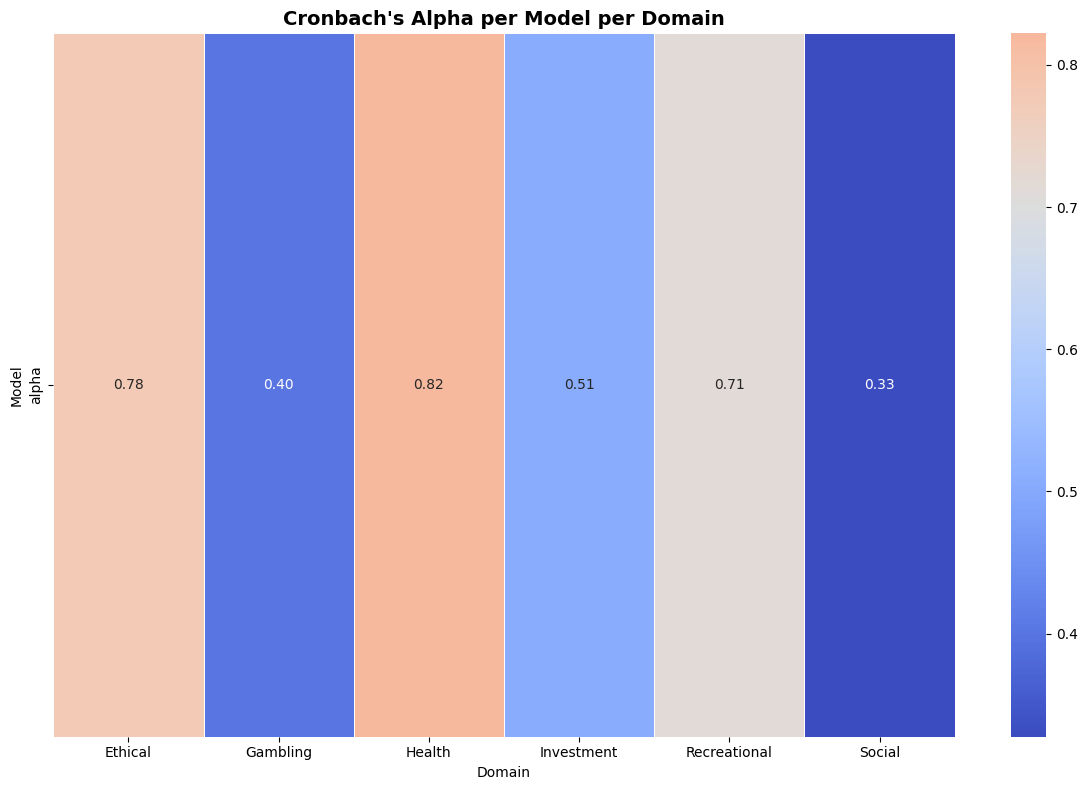

In [8]:
# Visualize Chronbach's Alpha for each model and category
plt.figure(figsize=(12, 8))
sns.heatmap(alphas_wide, annot=True, cmap="coolwarm", center=0.7, fmt=".2f", linewidths=.5)
plt.title("Cronbach's Alpha per Model per Domain", fontsize=14, weight="bold")
plt.xlabel("Domain")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

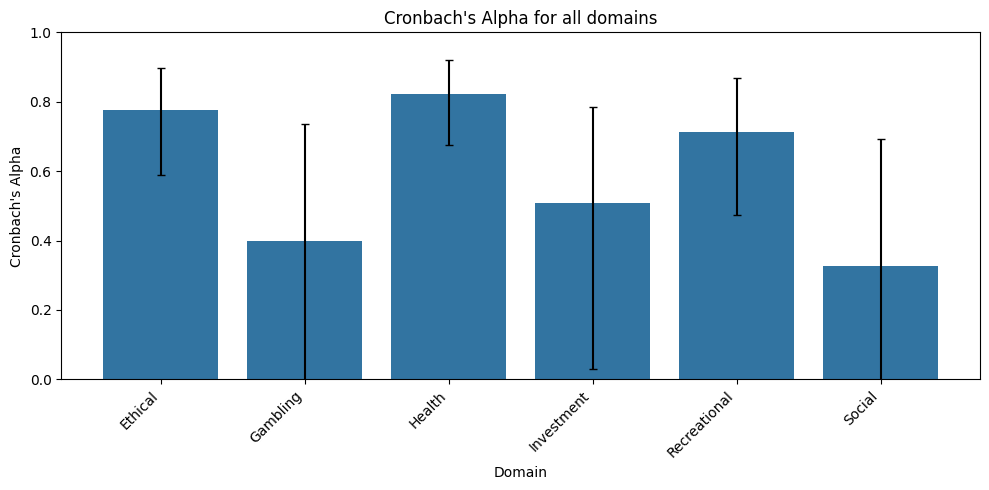

In [9]:
# loop through each domain and plot alphas per model

plt.figure(figsize=(10,5))
sns.barplot(data=alpha_df, x='domain', y='alpha')

plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)  # Cronbach's alpha range
plt.title(f"Cronbach's Alpha for all domains")
plt.ylabel("Cronbach's Alpha")
plt.xlabel("Domain")


# optionally, add CI as error bars if available
if 'alpha_CI' in alpha_df.columns:
    for i, row in alpha_df.iterrows():
        ci_low, ci_high =  row['alpha_CI']
        #print(ci_low, ci_high)
        plt.errorbar(
            x=i - alpha_df.index.min(),  # bar position
            y=row['alpha'],
            yerr=[[row['alpha'] - ci_low], [ci_high - row['alpha']]],
            fmt='none',
            c='black',
            capsize=3
        )

plt.tight_layout()
plt.show()


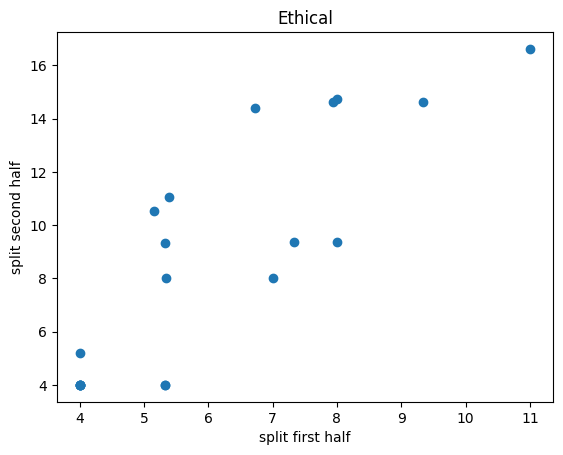

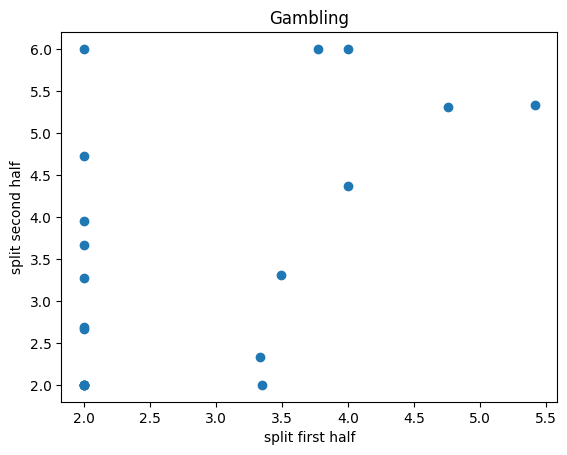

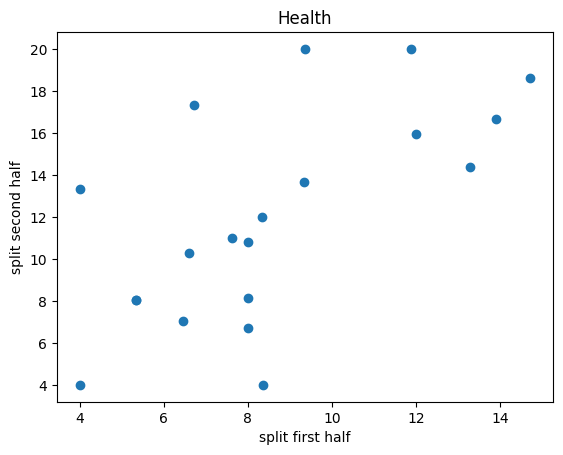

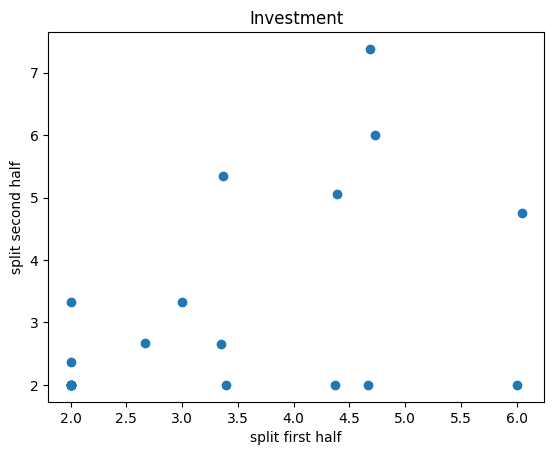

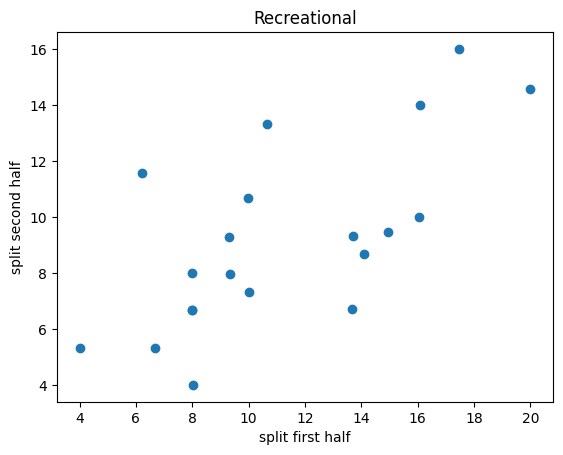

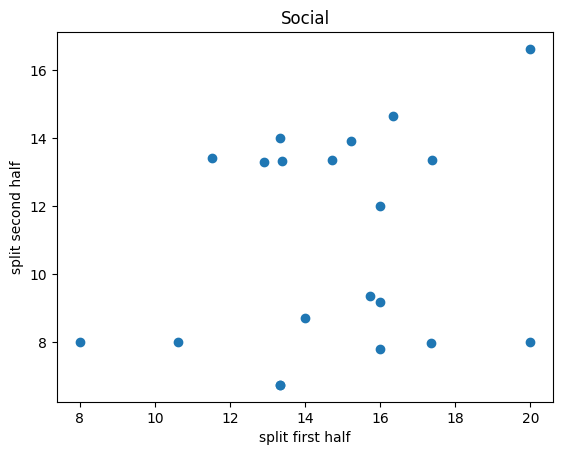

domain,Ethical,Gambling,Health,Investment,Recreational,Social
index,,,,,,
split_rel,0.803694,0.417942,0.829403,0.530534,0.719682,0.307999


In [10]:
# ---- split-half reliability -----

def split_half_reliability(df_items, n_splits=100, vis = False, domain = None):
    """Compute average split-half reliability (Spearman–Brown corrected)."""
    k = df_items.shape[1]
    colnames = df_items.columns
    results = []
    
    for i in range(n_splits):
        shuffled = list(colnames)
        random.shuffle(shuffled)
        half1, half2 = shuffled[:k//2], shuffled[k//2:]
        
        s1 = df_items[half1].sum(axis=1)
        s2 = df_items[half2].sum(axis=1)

        if vis == True and i == 1:
            plt.scatter(s1, s2)
            plt.xlabel("split first half")
            plt.ylabel("split second half")
            plt.title(f"{domain}")
            plt.show()

        r, _ = pearsonr(s1, s2)
        if np.isfinite(r): 
            r_sb = (2 * r) / (1 + r)
            results.append(r_sb)
        
    if results:
        return np.mean(results), np.std(results)
    else:
        return np.nan, np.nan  # No valid splits
    
split_results = []

# loop through domains
for domain, domain_data in model_item_scores.groupby("domain"):

    # pivot wide format for split half rel
    df_wide_domains = domain_data.pivot_table(
        index="model",
        columns="item",
        values="score"
    )
    #print(df_wide_domains)
    
    # calculate split-half rel
    rel, sd = split_half_reliability(df_wide_domains, vis = True, domain = domain)

    # store results
    split_results.append({
        "domain": domain,
        "split_rel": rel,
        "sd_split_rel": sd
    })

# convert to DataFrame
split_rel_df = pd.DataFrame(split_results)
split_rel_df

# transfer to wide format
split_rel_wide = split_rel_df.pivot_table(
    columns='domain',
    values='split_rel'
).reset_index()
split_rel_wide.set_index("index", inplace=True)
# show
split_rel_wide


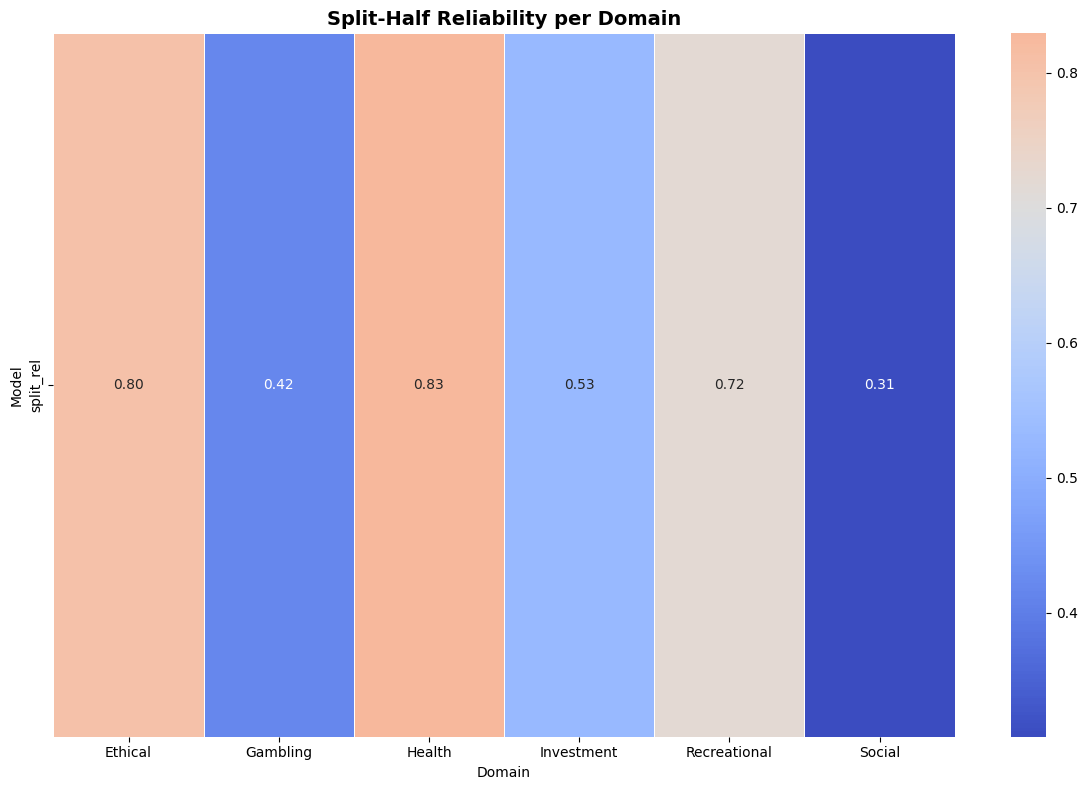

In [11]:
# Visualize Split-half reliability for each model and category
plt.figure(figsize=(12, 8))
sns.heatmap(split_rel_wide, annot=True, cmap="coolwarm", center=0.7, fmt=".2f", linewidths=.5)
plt.title("Split-Half Reliability per Domain", fontsize=14, weight="bold")
plt.xlabel("Domain")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

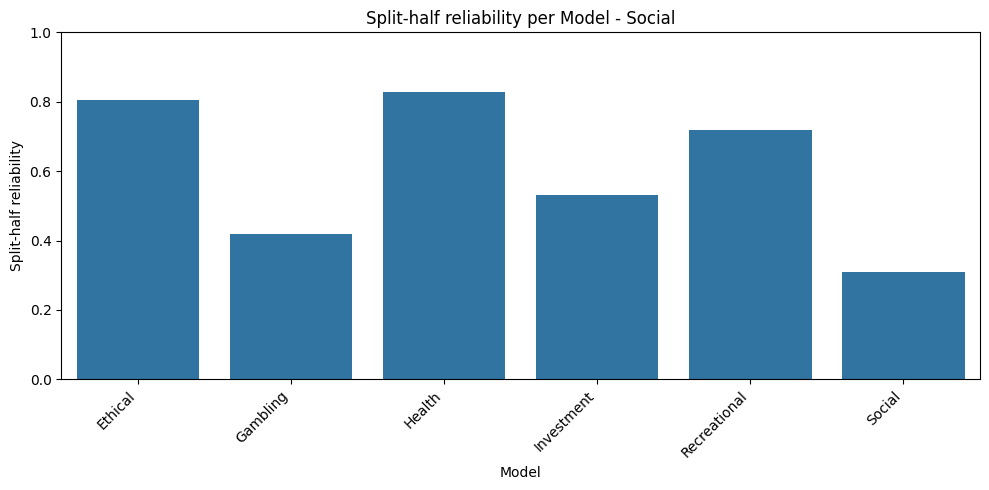

In [12]:
# loop through each domain and plot reliability per model
plt.figure(figsize=(10,5))
sns.barplot(data=split_rel_df, x='domain', y='split_rel')

plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.title(f"Split-half reliability per Model - {domain}")
plt.ylabel("Split-half reliability")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

## Calculating LLM outcomes - Very similar?


In [13]:
# ---- mean per domain ----
domains = (
    model_item_scores
    .groupby(["model", "domain"])["score"]
    .mean()
    .unstack()   # wide format: one column per domain
)

# rename domains to short labels
scores = domains.rename(columns={
    "Investment": "Dinv",
    "Gambling": "Dgam",
    "Health": "Dhea",
    "Recreational": "Drec",
    "Social": "Dsoc", 
    "Ethical": "Deth"
})

scores

domain,Deth,Dgam,Dhea,Dinv,Drec,Dsoc
model,,,,,,
Falcon-3-10B-Instruct,2.642718,2.687132,1.837316,1.499776,2.549110,3.136392
Falcon-3-1B-Instruct,1.667178,1.338287,3.670290,1.665790,2.000000,3.165901
Falcon-3-7B-Instruct,2.844075,2.500000,4.168890,2.000000,4.323126,3.844192
Llama-3.1-8B-Instruct,2.998060,2.000000,3.002804,1.000000,1.500973,2.326311
Llama-3.2-1B-Instruct,1.000000,1.317289,1.000000,1.000000,1.163857,1.999065
Llama-3.2-3B-Instruct,1.000000,1.000000,2.107809,1.000000,1.496681,2.976983
Ministral-8B-Instruct-2410,1.000000,1.000000,2.014931,2.682312,2.324874,3.508286
Mistral-7B-Instruct-v0.3,1.875000,1.416667,2.541667,1.333333,3.000000,3.500000
OLMo-2-7B-Instruct,3.453985,2.443125,3.819631,2.177522,3.255790,2.838574


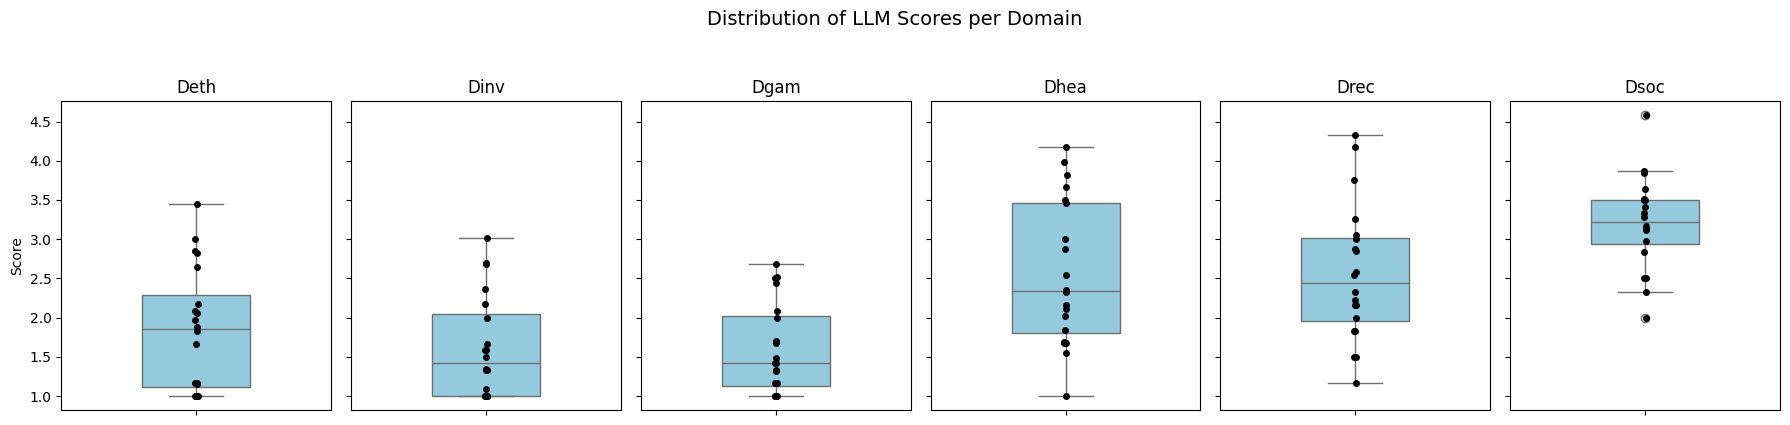

In [14]:
domains = ["Deth", "Dinv", "Dgam", "Dhea", "Drec", "Dsoc"]

fig, axes = plt.subplots(1, len(domains), figsize=(18,4), sharey=True)

for ax, dom in zip(axes, domains):
    sns.boxplot(y=scores[dom], ax=ax, color="skyblue", width=0.4)
    sns.stripplot(y=scores[dom], ax=ax, color="black", size=5, jitter=0.005)  
    ax.set_title(dom)
    #ax.set_xlabel("Domain")
    ax.set_ylabel("Score")
    #ax.set_ylim(1, 5)

plt.suptitle("Distribution of LLM Scores per Domain", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

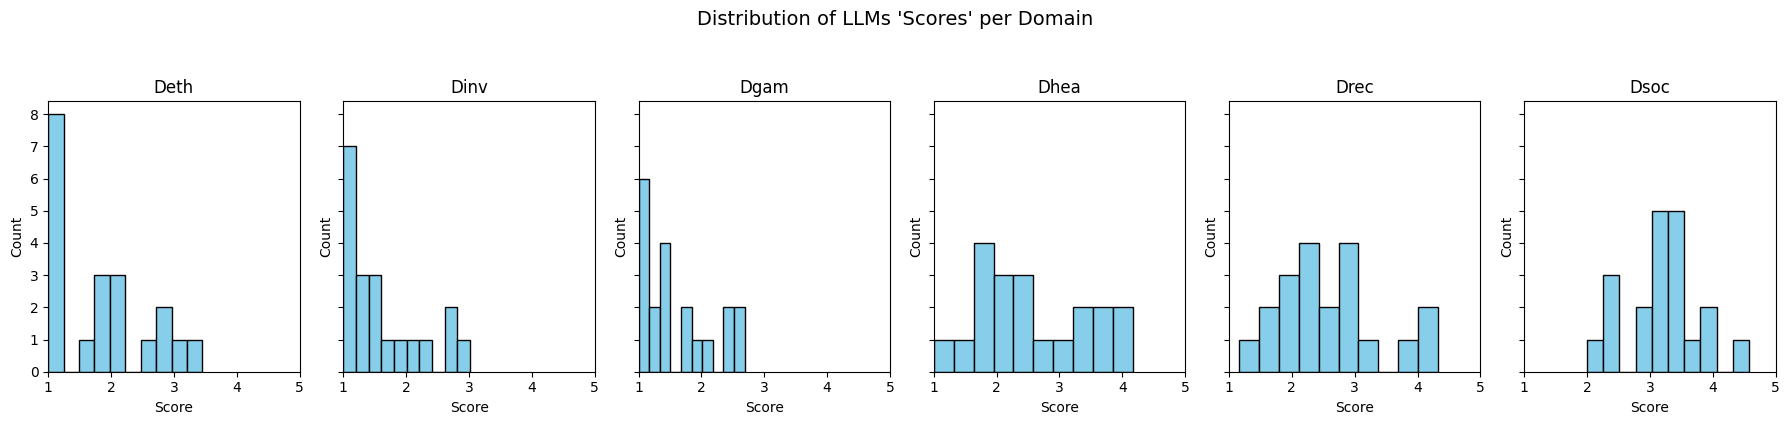

In [15]:
# visualize LLM distribution per domain
domains = ["Deth", "Dinv", "Dgam", "Dhea", "Drec", "Dsoc"]

fig, axes = plt.subplots(1, len(domains), figsize=(18,4), sharey=True)

for ax, dom in zip(axes, domains):
    ax.hist(scores[dom], bins=10, color="skyblue", edgecolor="black")
    ax.set_title(dom)
    ax.set_xlabel("Score")
    ax.set_ylabel("Count")
    ax.set_xlim(1, 5)

plt.suptitle("Distribution of LLMs 'Scores' per Domain", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

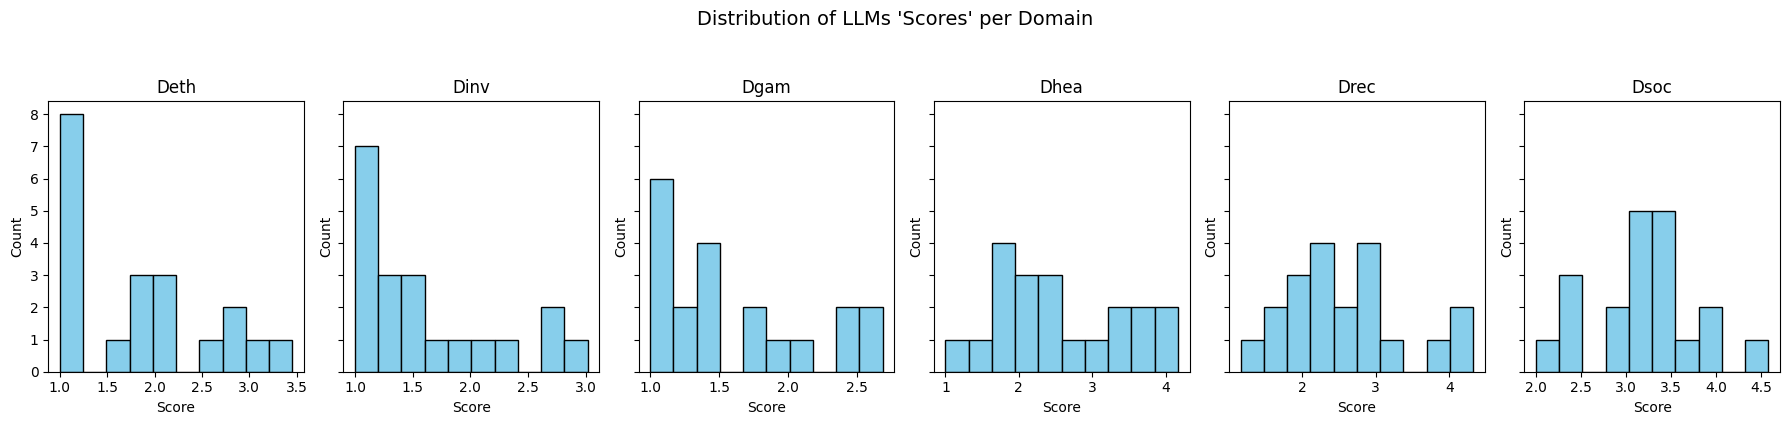

In [16]:
# ranzoomen:

fig, axes = plt.subplots(1, len(domains), figsize=(18,4), sharey=True)

for ax, dom in zip(axes, domains):
    ax.hist(scores[dom], bins=10, color="skyblue", edgecolor="black")
    ax.set_title(dom)
    ax.set_xlabel("Score")
    ax.set_ylabel("Count")

plt.suptitle("Distribution of LLMs 'Scores' per Domain", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

## Analyses on Human Data only

In [17]:
# ----- measure reliability of DOSPERT responses in humans ------------

# extract human answers
human_data = merged_dospert_data[merged_dospert_data["model"] == "Falcon-3-10B-Instruct"]

# to wide format for analyses
df_wide_human = human_data.pivot_table(
    index=['participant'],
    columns='item',
    values='human_number'
).reset_index()


# ---- Cronbach's alpha ----
df_wide_human_without_participant_id = df_wide_human.drop(columns=["participant"])
print(f"Cronbach's Alpha for human answers: {pg.cronbach_alpha(df_wide_human_without_participant_id)[0]}, Confidence Interval: {pg.cronbach_alpha(df_wide_human_without_participant_id)[1]}")


Cronbach's Alpha for human answers: 0.8810453592185342, Confidence Interval: [0.872 0.889]


In [18]:
# --- Calculate human cronbachs alpha divided by domain ---
# dictionary to store results
alphas = {}

# loop through domains
for domain, domain_data in human_data.groupby("domain"):
    # pivot wide format for this domain
    df_wide = domain_data.pivot_table(
        index="participant",
        columns="item",
        values="human_number"
    )
    # drop participant id if present
    df_wide = df_wide.dropna(axis=0)  # ensure no missing rows
    
    # calculate Cronbach's alpha
    alpha, ci = pg.cronbach_alpha(df_wide)
    
    alphas[domain] = {"alpha": alpha, "ci": ci}

alphas


{'Ethical': {'alpha': 0.785718737394081, 'ci': array([0.769, 0.802])},
 'Gambling': {'alpha': 0.7716849767368072, 'ci': array([0.752, 0.79 ])},
 'Health': {'alpha': 0.6852888367275239, 'ci': array([0.661, 0.709])},
 'Investment': {'alpha': 0.8213228655960135, 'ci': array([0.806, 0.836])},
 'Recreational': {'alpha': 0.8096413201624088, 'ci': array([0.795, 0.824])},
 'Social': {'alpha': 0.5784425933661972, 'ci': array([0.545, 0.61 ])}}

In [19]:
# ---- overall DOSPERT score per participant (all items) ----
# overall = (
#     human_data
#     .groupby("participant")["human_number"]
#     .mean()
#     .rename("DOSPERT")
# )

# ---- mean per domain ----
domains = (
    human_data
    .groupby(["participant", "domain"])["human_number"]
    .mean()
    .unstack()   # wide format: one column per domain
)

# rename domains to short labels
scores = domains.rename(columns={
    "Investment": "Dinv",
    "Gambling": "Dgam",
    "Health": "Dhea",
    "Recreational": "Drec",
    "Social": "Dsoc", 
    "Ethical": "Deth"
})

# ---- merge overall + domains into one dataframe ----
#scores = pd.concat([overall, domains], axis=1).reset_index()

scores.head(20)


domain,Deth,Dgam,Dhea,Dinv,Drec,Dsoc
participant,,,,,,
64000401,2.250,1.00,3.500,1.00,3.375,3.625
64004701,2.250,1.00,3.625,1.75,2.875,2.875
64006401,3.125,1.00,3.875,1.00,2.500,3.250
64006901,1.375,1.25,2.875,2.75,2.500,3.500
64007901,1.500,1.00,2.500,3.00,2.875,3.125
64008701,1.250,1.75,1.625,2.25,2.000,3.125
64011501,2.875,1.25,3.750,1.00,2.875,4.125
64015601,1.250,1.00,1.750,1.75,1.750,3.000
64016901,2.750,2.50,2.500,3.50,2.875,3.250


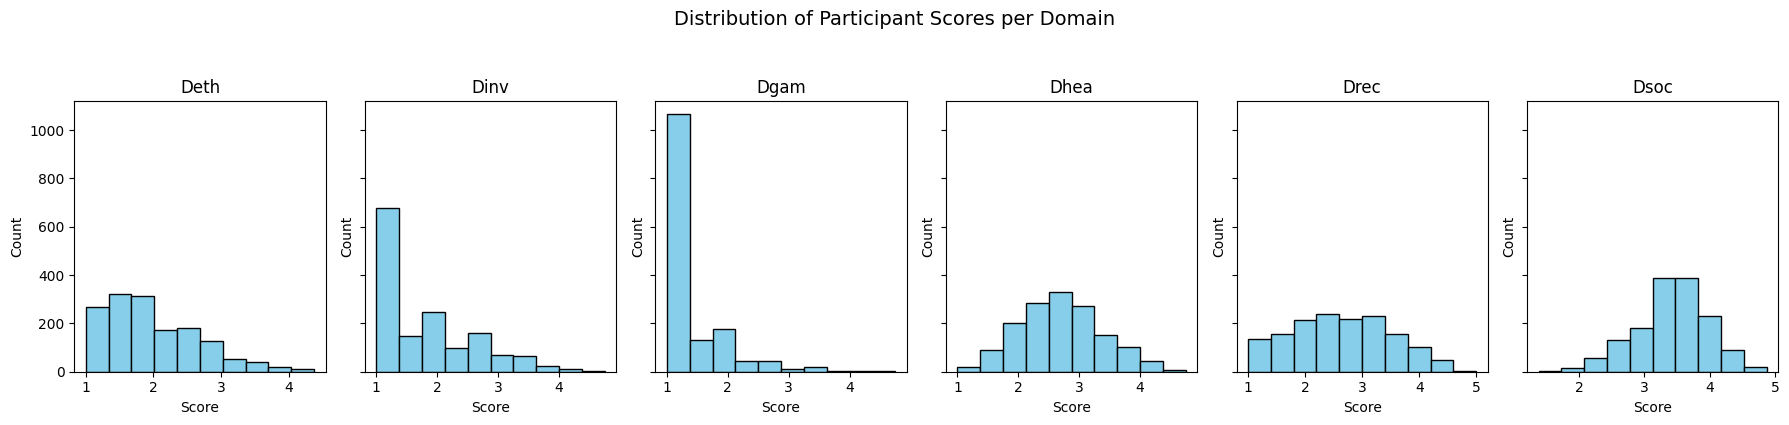

In [20]:
# visualize human distribution per domain
domains = ["Deth", "Dinv", "Dgam", "Dhea", "Drec", "Dsoc"]

fig, axes = plt.subplots(1, len(domains), figsize=(18,4), sharey=True)

for ax, dom in zip(axes, domains):
    ax.hist(scores[dom], bins=10, color="skyblue", edgecolor="black")
    ax.set_title(dom)
    ax.set_xlabel("Score")
    ax.set_ylabel("Count")

plt.suptitle("Distribution of Participant Scores per Domain", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()
